In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
root_path = '../'
sys.path.append(os.path.join(root_path, 'code'))
import pandas as pd
import sklearn
import numpy as np

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import snorkel



In [2]:
# Load data
df=pd.read_csv('anomaly.csv', sep=',',header=None)
df2=pd.read_csv('noisesimulation1.csv', sep=',',header=None)


In [3]:
# Each row is a collision event summarized by 5 features.  The first feature is “m” and the other four features are “x”.   I would suggest using 3.3 < m. <3.7 as the signal region and everything else as the sideband.  So if you want mixed samples, you can call all noise/anomaly in the signal region as class 1 and then everything else as class 0.  
# set up the datasets according to the above
X1 = df.to_numpy()
X2 = df2.to_numpy()

# join the datasets; first part is the anomaly part
X = np.concatenate((X1, X2))
n1 = X1.shape[0]
n2 = X2.shape[0]
n = X.shape[0]

# get the noisy labels using the signal and sideband regions
Y = np.zeros(n)
for i in range(n):
    Y[i] = 1 if (X[i, 0] > 3.3 and X[i,0] < 3.7) else 0

# construct the true labels
Y_true = np.zeros(n)
Y_true[:X1.shape[0]] = 1.0 # anomaly 

# set up constants
# for LLP, we need to get these---potentially from tuning
L_rho = 1/(1-0.2-0.3)
delta = 0.01

In [6]:
n_pts = 20
#n_ratios = list(np.logspace(0.5, 2.5, num=n_pts)/10**4)
n_ratios = np.linspace(0.0005, 0.06,num=n_pts)
print(n_ratios[0]*400000, n_ratios[9]*400000)


200.0 11473.684210526317


In [7]:
# run a cwola-like model and evaluate
# let's also construct smaller versions
num_runs = 50
cwola_scores = np.zeros((n_pts, num_runs))

for a in range(len(n_ratios)):
    for b in range(num_runs):
        n1a = int(n_ratios[a]*n1)
        n2a = int(n_ratios[a]*n2)
        X = np.concatenate((X1[np.random.permutation(n1)][:n1a], X2[np.random.permutation(n2)][:n2a]))
        Y = np.zeros(n1a+n2a)
        for i in range(n1a+n2a):
            Y[i] = 1 if (X[i, 0] > 3.3 and X[i,0] < 3.7) else 0
        Y_true=np.zeros(n1a+n2a)
        Y_true[:n1a] = 1.0 # anomaly
        clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
        clf.fit(X, Y)
        cwola_scores[a, b] = sklearn.metrics.accuracy_score(Y_true, clf.predict(X))
cwola_accs = cwola_scores.sum(axis=1) / num_runs
cwola_stds= cwola_scores.std(axis=1)
print(f"Cwola accuracy = {cwola_accs} std = {cwola_stds}")


Cwola accuracy = [0.62531401 0.63541914 0.63837646 0.6432655  0.64733162 0.64486278
 0.64417298 0.6345954  0.64559797 0.63568683 0.63137713 0.63790138
 0.63403537 0.63700244 0.6368726  0.64104105 0.63574121 0.63150045
 0.63799469 0.63594631] std = [0.13208178 0.09193377 0.06987829 0.05368842 0.05177343 0.05112745
 0.0378145  0.03258496 0.04461988 0.03317996 0.02581353 0.02885243
 0.02356224 0.03607951 0.03040003 0.02280808 0.02593541 0.02375851
 0.02097621 0.02453574]


In [9]:
# snorkel-like approach where we vary the thresholds to build LFs
# note: non-independent LFs here, so the analysis doesn't go through

# to keep from getting overwhelmed with reporting spew
import logging, sys, time
from tqdm import tqdm
from snorkel.labeling.model import LabelModel
from snorkel.utils import probs_to_preds
from functools import partialmethod

logging.disable(sys.maxsize)
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

# for reproducibility:
'''
np.random.seed(123)
# create multiple datasets that become our LFs b
m = X.shape[1]

for k in range(n_pts):
    tol = -0.06 + 0.01*k
    print(f"tol = {tol}")
    L = np.zeros((n, m))

    for j in range(m):
        for i in range(n):
            L[i, j] = 1 if (X[i, 0] > (3.3 - j*tol) and X[i,0] < (3.7 + j*tol)) else 0
    print()

    label_model = LabelModel(cardinality=2)
    label_model.fit(L_train=L, n_epochs=500, log_freq=100, seed=123)
    probs_train = label_model.predict_proba(L)
    #probs_one = probs_train[:,1]
    preds_train = probs_to_preds(probs=probs_train)

    clf_end_model = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
    clf_end_model.fit(X, preds_train)
    snorkel_accuracy = sklearn.metrics.accuracy_score(Y_true, clf_end_model.predict(X))
    print(f"Snorkel accuracy = {snorkel_accuracy}")
    for j in range(5):
        print(np.sum(L[:,j] == 1)/L.shape[0])
    print()
'''

'\nnp.random.seed(123)\n# create multiple datasets that become our LFs b\nm = X.shape[1]\n\nfor k in range(n_pts):\n    tol = -0.06 + 0.01*k\n    print(f"tol = {tol}")\n    L = np.zeros((n, m))\n\n    for j in range(m):\n        for i in range(n):\n            L[i, j] = 1 if (X[i, 0] > (3.3 - j*tol) and X[i,0] < (3.7 + j*tol)) else 0\n    print()\n\n    label_model = LabelModel(cardinality=2)\n    label_model.fit(L_train=L, n_epochs=500, log_freq=100, seed=123)\n    probs_train = label_model.predict_proba(L)\n    #probs_one = probs_train[:,1]\n    preds_train = probs_to_preds(probs=probs_train)\n\n    clf_end_model = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))\n    clf_end_model.fit(X, preds_train)\n    snorkel_accuracy = sklearn.metrics.accuracy_score(Y_true, clf_end_model.predict(X))\n    print(f"Snorkel accuracy = {snorkel_accuracy}")\n    for j in range(5):\n        print(np.sum(L[:,j] == 1)/L.shape[0])\n    print()\n'

In [10]:
# snorkel approach
import logging, sys, time
from tqdm import tqdm
from functools import partialmethod

logging.disable(sys.maxsize)
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

n, m = X.shape

# I made these thresholds
thresholds = np.array([[3.3, 3.7], [0.09, 0.12], [0.33, 0.40], [0.3, 0.5], [0.1, 0.3]])

snorkel_scores = np.zeros((n_pts, num_runs))
label_model = LabelModel(cardinality=2)

for a in range(len(n_ratios)):
    st = time.time()
    for b in range(num_runs):
        n1a = int(n_ratios[a]*n1)
        n2a = int(n_ratios[a]*n2)

        # make each feature a separate LF in here
        L = np.zeros((n1a+n2a, m))
        nperm1 = np.random.permutation(n1)

        X = np.concatenate((X1[nperm1][:n1a], X2[np.random.permutation(n2)][:n2a]))
        Y = np.zeros(n1a+n2a)
        for i in range(n1a+n2a):
            Y[i] = 1 if (X[i, 0] > 3.3 and X[i,0] < 3.7) else 0
        Y_true=np.zeros(n1a+n2a)
        Y_true[:n1a] = 1.0 # anomaly
        for i in range(n1a+n2a):
            L[i, 0] = 1 if (X[i, 0] > thresholds[0,0] and X[i, 0] < thresholds[0,1]) else 0
            L[i, 1] = 1 if (X[i, 1] > thresholds[1,0] and X[i, 1] < thresholds[1,1]) else 0
            L[i, 2] = 1 if (X[i, 2] > thresholds[2,0] and X[i, 2] < thresholds[2,1]) else 0
            L[i, 3] = 1 if (X[i, 3] > thresholds[3,0] and X[i, 3] < thresholds[3,1]) else 0
            L[i, 4] = 1 if (X[i, 4] > thresholds[4,0] and X[i, 4] < thresholds[4,1]) else 0

        label_model.fit(L_train=L, n_epochs=500, log_freq=100, seed=np.random.randint(1e6))
        probs_train = label_model.predict_proba(L)
        preds_train = probs_to_preds(probs=probs_train)

        clf_end_model = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
        clf_end_model.fit(X, preds_train)
        snorkel_scores[a, b] = sklearn.metrics.accuracy_score(Y_true, clf_end_model.predict(X))
    print(f"finished with num labels {n1a+n2a} in {time.time()-st}")
snorkel_accs = snorkel_scores.sum(axis=1) / num_runs
snorkel_stds = snorkel_scores.std(axis=1)
print(f"Snorkel accuracy = {snorkel_accs} std = {snorkel_stds}")


finished with num labels 207 in 15.853958368301392
finished with num labels 1515 in 15.987717866897583
finished with num labels 2821 in 26.364206075668335
finished with num labels 4128 in 26.127989530563354
finished with num labels 5434 in 25.64449119567871
finished with num labels 6741 in 25.56728744506836
finished with num labels 8047 in 29.420825481414795
finished with num labels 9355 in 27.40245795249939
finished with num labels 10661 in 29.506767749786377
finished with num labels 11968 in 30.33250665664673
finished with num labels 13274 in 28.824297189712524
finished with num labels 14581 in 28.36620831489563
finished with num labels 15887 in 29.107901573181152
finished with num labels 17194 in 29.46170735359192
finished with num labels 18501 in 26.902440309524536
finished with num labels 19807 in 21.06597399711609
finished with num labels 21114 in 22.801905870437622
finished with num labels 22420 in 22.89540457725525
finished with num labels 23727 in 22.68857979774475
finished wi

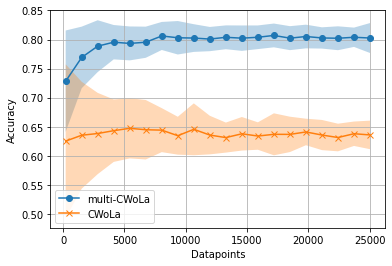

In [24]:
import matplotlib.pyplot as plt
fig = plt.gcf()
#fig.set_size_inches(18.5, 10.5)

n_labels = np.zeros(n_pts)

for a in range(len(n_ratios)):
    n1a = int(n_ratios[a]*n1)
    n2a = int(n_ratios[a]*n2)
    n_labels[a] = n1a+n2a
#fig.set_size_inches(18.5, 10.5, forward=True)

plt.plot(n_labels, snorkel_accs, label='multi-CWoLa', marker="o")
plt.fill_between(n_labels, snorkel_accs-snorkel_stds, snorkel_accs+snorkel_stds, alpha=0.3)
plt.plot(n_labels, cwola_accs, label='CWoLa', marker="x")
plt.fill_between(n_labels, cwola_accs-cwola_stds, cwola_accs+cwola_stds, alpha=0.3)

plt.ylabel('Accuracy')
plt.xlabel('Datapoints')
plt.legend()
plt.grid()
ax = fig.axes[0]
ax.set_rasterized(True)

fig.savefig('bla.pdf', dpi=300)

#plt.show()
